In [7]:
# pip install --force-reinstall --upgrade git+https://github.com/SerjWeesp/AmarinML.git

In [8]:
from amarinml import *

In [ ]:
from probatus.feature_elimination import ShapRFECV
from skopt.space import Real, Integer
from skopt import BayesSearchCV
from catboost import CatBoostRegressor, Pool
from feature_engine.outliers import OutlierTrimmer
from feature_engine.encoding import RareLabelEncoder
from feature_engine.selection import DropConstantFeatures, DropCorrelatedFeatures, RecursiveFeatureElimination
import shap
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, PowerTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score
import numpy as np
import pandas as pd
import copy
import os
import joblib

os.environ.pop("OPENBLAS_NUM_THREADS", None)  # None = ignore if not present
SEED = 23
pd.set_option('display.max_columns', None)

In [12]:
# Define RMSE scoring function
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [13]:
df = pd.read_csv('D:\GitHub\sp500\sp500_diff.csv', low_memory=False)
df.drop(columns=['Unnamed: 0'], axis=1, inplace=True)
df.replace([np.inf, -np.inf], 0, inplace=True)
df.sort_values(by=['Ticker', 'Date'], inplace=True)
print(df.shape)

(7782, 1133)


In [14]:
target = 'Future_Price_pct_diff_1'
df[target] = df.groupby('Ticker')['ClosePrice_pct_diff_1'].shift(1)
df.dropna(inplace=True)
features = df.drop(columns=[target], axis=1).columns.tolist()
cat_features = df.drop(columns=[target], axis=1).select_dtypes(
    include=['object', 'category']).columns.tolist()
num_features = df.drop(columns=[target], axis=1).select_dtypes(
    include=['int64', 'float64']).columns.tolist()
print(
    f'Length of numerical features: {len(num_features)}, categorical: {len(cat_features)} , all features: {len(features)}')

Length of numerical features: 1129, categorical: 4 , all features: 1133


In [15]:
split_date = '2024-01-01'
train_df, test_df = df.loc[df['Date'] <
                           split_date], df.loc[df['Date'] >= split_date]

In [16]:
X_train = train_df[features]
y_train = train_df[target]
X_test = test_df[features]
y_test = test_df[target]

In [17]:
model = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.1,
    depth=8,
    random_seed=SEED,
    verbose=False,
    thread_count=-1,
    devices='0',
    task_type="GPU",
    gpu_ram_part=0.99,
    data_partition='DocParallel',
    max_ctr_complexity=2,
    cat_features=cat_features,
)

tscv = TimeSeriesSplit(n_splits=3)

scores = cross_val_score(model, X_train, y_train, cv=tscv,
                         scoring='neg_root_mean_squared_error')
print(scores)

[-0.073817   -0.0703262  -0.06260707]


In [18]:
model.fit(X_train, y_train, cat_features=cat_features,
          eval_set=(X_test, y_test), verbose=False)

# Retrieve feature importances
importances = model.get_feature_importance()

# Retrieve the corresponding feature names (if available)
feature_names = model.feature_names_

# Create a DataFrame with the feature names and their importances
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
})

# Sort the DataFrame in descending order by importance
importance_df = importance_df.sort_values(by='importance', ascending=False)

# Print the top 30 important features
print(importance_df.head(30))

                                      feature  importance
741                    MACD_Signal_pct_diff_1   13.709025
765                       MinPrice_pct_diff_1   13.185725
961                         RSI_14_pct_diff_1   11.760894
749                       MaxPrice_pct_diff_1    6.920915
182                               MACD_Signal    6.436828
292                                    RSI_14    4.371814
1                                        Date    3.879093
737                           MACD_pct_diff_1    2.602544
181                                 MACD_Hist    1.943212
290                                   Quarter    1.636373
766                       MinPrice_pct_diff_4    1.260571
463                     ClosePrice_pct_diff_1    1.253044
691               Last Close Price_pct_diff_1    1.122958
1047                      StdPrice_pct_diff_1    1.027145
962                         RSI_14_pct_diff_4    1.004654
464                     ClosePrice_pct_diff_4    0.866645
180           

In [19]:
selected = ['Ticker', 'Date', 'MACD_Signal', 'Quarter', 'RSI_14', 'GICS Sector', 'GICS Sub-Industry',
            'ClosePrice_pct_diff_1', 'MACD_Signal_pct_diff_1', 'MaxPrice_pct_diff_1', 'MinPrice_pct_diff_1', 'RSI_14_pct_diff_1']

In [ ]:
n_iter = 30
tscv = TimeSeriesSplit(n_splits=3)

# Define search space
param_space = {
    # ,'subsample': Real(0.5, 1.0)

    'learning_rate': Real(0.01, 0.3, prior='log-uniform'),
    'depth': Integer(3, 8),
    'l2_leaf_reg': Real(1e-9, 10, prior='log-uniform'),
    'iterations': Integer(100, 1000),
    'random_strength': Real(1e-9, 10, prior='log-uniform'),
    'bagging_temperature': Real(0.0, 1.0),
    'min_data_in_leaf': Integer(1, 100),
    'leaf_estimation_iterations': Integer(1, 20)
}

# Initialize the progress bar with the number of iterations
callback = TqdmCallback(total=n_iter)

opt = BayesSearchCV(
    estimator=model,
    search_spaces=param_space,
    n_iter=n_iter,
    cv=None,
    scoring=make_scorer(rmse, greater_is_better=False),
    n_jobs=1,
    n_points=8,
    random_state=SEED
)


# Fit gs
opt.fit(X_train[selected], y_train, cat_features=cat_features,
        callback=callback, verbose=False)

# Retrieve the best model and results
best_model = opt.best_estimator_
results = opt.cv_results_
params = results['params']

# Best model and parameters
print("Best score:", opt.best_score_)
print("Best params:", opt.best_params_)

joblib.dump(best_model, 'sp500_best_catboost_model.pkl')

100%|██████████| 30/30 [29:45<00:00, 63.90s/it]

Best score: -0.05638029629789924
Best params: OrderedDict([('bagging_temperature', 0.0), ('depth', 8), ('iterations', 1000), ('l2_leaf_reg', 10.0), ('leaf_estimation_iterations', 20), ('learning_rate', 0.062066146625371264), ('min_data_in_leaf', 1), ('random_strength', 1e-09)])


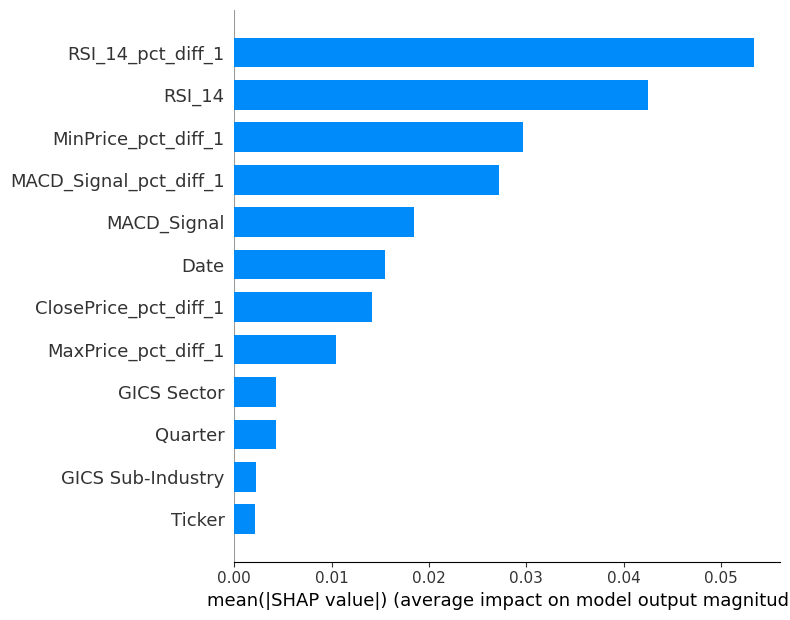

In [28]:
# Use the best model and the selected features
explainer = shap.Explainer(best_model)
shap_values = explainer(X_test[selected])

# Global summary plot (bar)
shap.summary_plot(shap_values, X_test[selected], plot_type="bar")

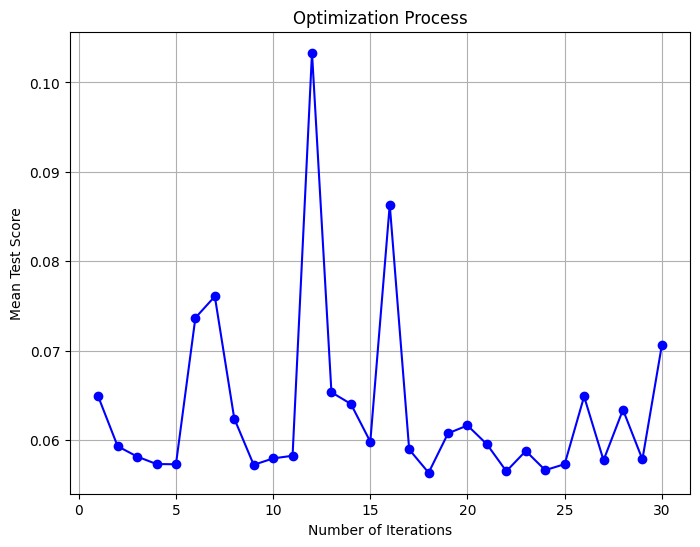

In [29]:
# Extract the results
results = pd.DataFrame(opt.cv_results_)
results['mean_test_score'] = -results['mean_test_score']

# Extract the mean test scores and number of iterations
iterations = np.arange(1, n_iter + 1)

# Plot the scores
plt.figure(figsize=(8, 6))
plt.plot(iterations, results['mean_test_score'],
         marker='o', linestyle='-', color='b')
plt.xlabel('Number of Iterations')
plt.ylabel('Mean Test Score')
plt.title('Optimization Process')
plt.grid(True)
plt.show()

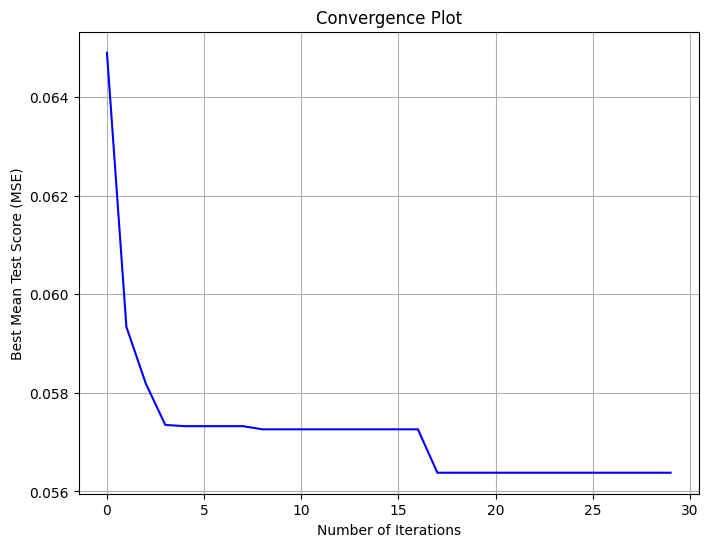

In [30]:
# Extract best scores at each iteration
best_scores = np.minimum.accumulate(results['mean_test_score'])

# Plot the convergence
plt.figure(figsize=(8, 6))
plt.plot(best_scores, linestyle='-', color='b')
plt.xlabel('Number of Iterations')
plt.ylabel('Best Mean Test Score (MSE)')
plt.title('Convergence Plot')
plt.grid(True)
plt.show()

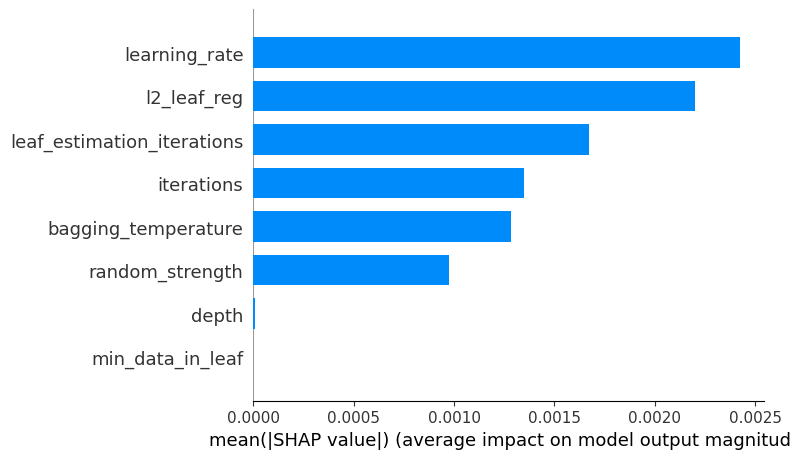

In [33]:

# Mean test scores are negative due to the scoring used
mean_test_scores = -results['mean_test_score']

# Create a DataFrame for analysis
hyperparams_df = pd.DataFrame(params)
hyperparams_df['mean_test_score'] = mean_test_scores

# If any hyperparameters are strings (e.g. loss_function), encode them
for col in hyperparams_df.drop('mean_test_score', axis=1).select_dtypes(include='object').columns:
    hyperparams_df[col] = hyperparams_df[col].astype('category').cat.codes

# Rebuild a fresh CatBoostRegressor with the best hyperparameters from search
best_params = opt.best_params_

# Fit a simple model to explain the hyperparameter importance
hyperparam_model = CatBoostRegressor(**best_params, verbose=0)

hyperparam_model.fit(
    hyperparams_df.drop('mean_test_score', axis=1),
    hyperparams_df['mean_test_score']
)

hyperparam_model.fit(hyperparams_df.drop(
    'mean_test_score', axis=1), hyperparams_df['mean_test_score'])


# Create a SHAP explainer
explainer = shap.Explainer(hyperparam_model)
shap_values = explainer(hyperparams_df.drop('mean_test_score', axis=1))

# Plot feature importance based on SHAP values
shap.summary_plot(shap_values, hyperparams_df.drop(
    'mean_test_score', axis=1), plot_type="bar")

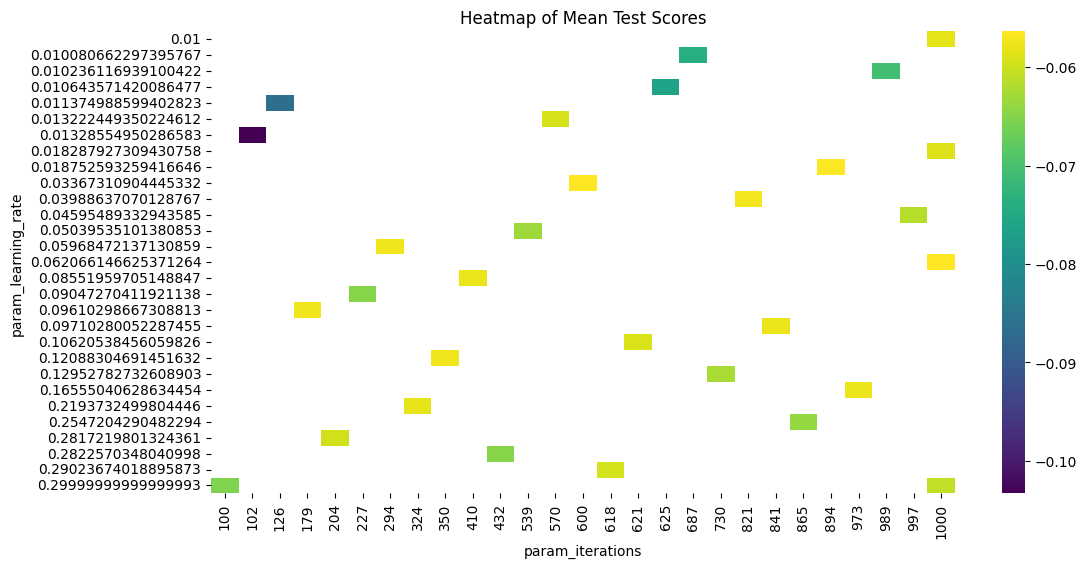

In [35]:
# Create a pivot table for the heatmap
pivot_table = pd.DataFrame(results).pivot_table(
    values='mean_test_score',
    index='param_learning_rate',
    columns='param_iterations',
    aggfunc='mean'
)

# Plot the heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(pivot_table, annot=False, fmt=".1f", cmap="viridis")
plt.title('Heatmap of Mean Test Scores')
plt.show()

In [39]:
# Predict on the test set using the best model
preds = best_model.predict(X_test[selected])

errors = np.abs(test_df[target] - preds)


# Create a DataFrame to store actual, predicted, and errors

error_df = test_df[['Ticker', 'Date', target]].copy()

error_df['Predicted'] = preds

error_df['Absolute Error'] = errors


# Sort by error in descending order and display the top 30

top_30_errors = error_df.sort_values(
    by='Absolute Error', ascending=False).head(30)

print(top_30_errors)

     Ticker        Date  Future_Price_pct_diff_1  Predicted  Absolute Error
6407   SMCI  2024-06-30                 2.553191   0.303805        2.249386
5834   PLTR  2025-03-31                 1.033064   0.601342        0.431723
7362    VST  2024-06-30                 0.814395   0.470495        0.343900
6883    TPL  2025-03-31                 0.251291  -0.067072        0.318363
7605    WSM  2025-02-02                -0.129893   0.183344        0.313237
3007   FSLR  2024-09-30                 0.335664   0.054351        0.281313
7091    UAL  2025-03-31                 0.701717   0.447118        0.254599
2034   DELL  2024-08-02                 0.454895   0.209918        0.244977
6979   TSLA  2025-03-31                 0.543554   0.311063        0.232491
7152   ULTA  2024-05-04                 0.330271   0.100440        0.229830
6807    TGT  2024-05-04                 0.370857   0.151967        0.218890
2032   DELL  2024-02-02                 0.312968   0.109486        0.203482
6978   TSLA 

<Axes: >

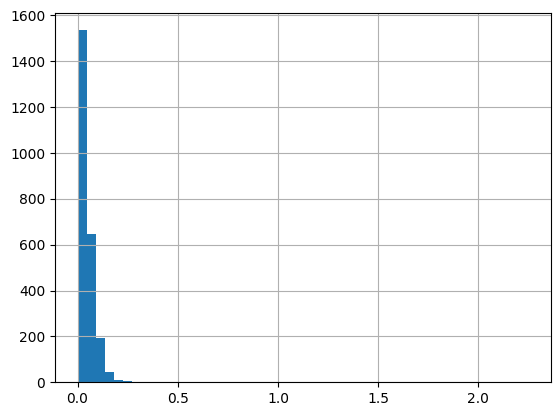

In [ ]:
error_df['Absolute Error'].hist(bins=50)

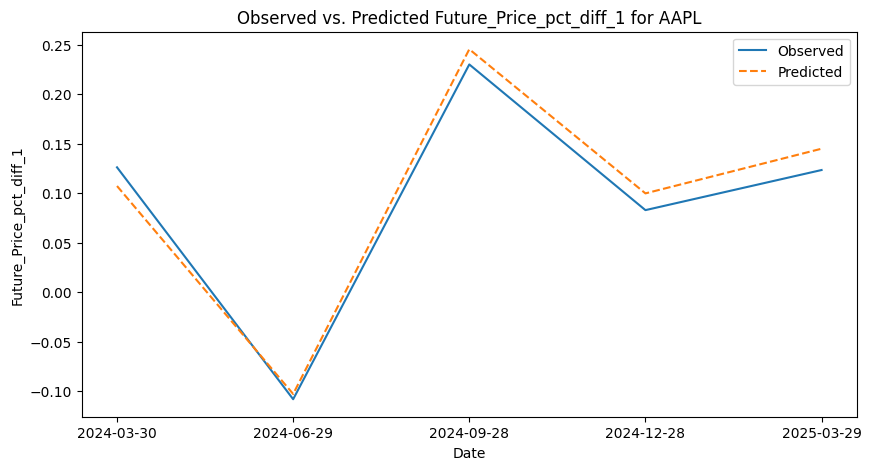

Mean absolute error: 0.015596139518879965


In [47]:
ticker = 'AAPL'

ticker_example = test_df[test_df['Ticker'] == ticker]
plt.figure(figsize=(10, 5))
plt.plot(ticker_example['Date'], ticker_example[target], label='Observed')
plt.plot(ticker_example['Date'], best_model.predict(Pool(ticker_example[features], cat_features=cat_features)),
         label='Predicted', linestyle='--')
plt.title(f'Observed vs. Predicted {target} for {ticker}')
plt.xlabel('Date')
plt.ylabel(target)
plt.legend()
plt.show()

print(
    f'Mean absolute error: {error_df.loc[error_df["Ticker"]==ticker, "Absolute Error"].mean()}')

In [ ]:
from sklearn.preprocessing import OrdinalEncoder
from lightgbm import LGBMRegressor, early_stopping, log_evaluation
from sklearn.metrics import mean_squared_error

# Make a copy of your data to avoid modifying the original
X_train_encoded = X_train[selected].copy()
X_test_encoded = X_test[selected].copy()

# Initialize ordinal encoder
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

# Encode categorical features
X_train_encoded[cat_features] = encoder.fit_transform(X_train[cat_features])
X_test_encoded[cat_features] = encoder.transform(X_test[cat_features])

# Now convert to proper numeric types
X_train_encoded = X_train_encoded.astype('float32')
X_test_encoded = X_test_encoded.astype('float32')

# Update categorical features indices (now they're numeric)
cat_features_lgbm = [X_train_encoded.columns.get_loc(
    col) for col in cat_features if col in selected]

# Train the model
lgbm_model = LGBMRegressor(
    n_estimators=1000,
    learning_rate=0.1,
    max_depth=8,
    random_state=SEED
)

lgbm_model.fit(
    X_train_encoded, y_train,
    eval_set=[(X_test_encoded, y_test)],
    eval_metric='rmse',
    categorical_feature=cat_features_lgbm,
    callbacks=[
        early_stopping(stopping_rounds=50),
        log_evaluation(100)
    ]
)

# Predict and evaluate
lgbm_preds = lgbm_model.predict(X_test_encoded)
lgbm_rmse = np.sqrt(mean_squared_error(y_test, lgbm_preds))
print("LGBM Test RMSE:", lgbm_rmse)

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Total Bins 2512
[LightGBM] [Info] Number of data points in the train set: 4851, number of used features: 12
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 0.017847
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[100]	valid_0's rmse: 0.0744654
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

In [75]:
# Torch LSTM challenger model for time series prediction

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler

# --- Prepare data for LSTM ---
# We'll use only numerical features for LSTM
lstm_features = [col for col in num_features if col in selected and col not in [
    'Date']]  # Exclude 'Date' if not numeric

# Scale features
scaler = StandardScaler()
X_train_lstm = scaler.fit_transform(X_train[lstm_features])
X_test_lstm = scaler.transform(X_test[lstm_features])

# Convert to tensors
X_train_tensor = torch.tensor(X_train_lstm, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_lstm, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

# Reshape for LSTM: (samples, sequence_length, features)
# For simplicity, treat each row as a separate sequence of length 1
X_train_tensor = X_train_tensor.unsqueeze(1)
X_test_tensor = X_test_tensor.unsqueeze(1)


class TabularDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


train_dataset = TabularDataset(X_train_tensor, y_train_tensor)
test_dataset = TabularDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

# --- Define LSTM Model ---


class LSTMRegressor(nn.Module):
    def __init__(self, input_dim, hidden_dim=32, num_layers=1):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim,
                            num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]  # Take last output
        out = self.fc(out)
        return out.squeeze()


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTMRegressor(input_dim=len(lstm_features)).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# --- Training loop ---
epochs = 100
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * X_batch.size(0)
    print(
        f"Epoch {epoch+1}/{epochs}, Train Loss: {total_loss/len(train_loader.dataset):.4f}")

# --- Evaluation ---
model.eval()
with torch.no_grad():
    preds = []
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        batch_preds = model(X_batch).cpu().numpy()
        preds.append(batch_preds)
    preds = np.concatenate(preds)
    lstm_rmse = np.sqrt(np.mean((preds - y_test_tensor.numpy()) ** 2))
    print("LSTM Test RMSE:", lstm_rmse)

Epoch 1/100, Train Loss: 0.0197
Epoch 2/100, Train Loss: 0.0071
Epoch 3/100, Train Loss: 0.0063
Epoch 4/100, Train Loss: 0.0060
Epoch 5/100, Train Loss: 0.0057
Epoch 6/100, Train Loss: 0.0056
Epoch 7/100, Train Loss: 0.0055
Epoch 8/100, Train Loss: 0.0054
Epoch 9/100, Train Loss: 0.0053
Epoch 10/100, Train Loss: 0.0052
Epoch 11/100, Train Loss: 0.0051
Epoch 12/100, Train Loss: 0.0051
Epoch 13/100, Train Loss: 0.0050
Epoch 14/100, Train Loss: 0.0050
Epoch 15/100, Train Loss: 0.0050
Epoch 16/100, Train Loss: 0.0049
Epoch 17/100, Train Loss: 0.0049
Epoch 18/100, Train Loss: 0.0049
Epoch 19/100, Train Loss: 0.0048
Epoch 20/100, Train Loss: 0.0048
Epoch 21/100, Train Loss: 0.0048
Epoch 22/100, Train Loss: 0.0048
Epoch 23/100, Train Loss: 0.0048
Epoch 24/100, Train Loss: 0.0048
Epoch 25/100, Train Loss: 0.0048
Epoch 26/100, Train Loss: 0.0047
Epoch 27/100, Train Loss: 0.0048
Epoch 28/100, Train Loss: 0.0047
Epoch 29/100, Train Loss: 0.0047
Epoch 30/100, Train Loss: 0.0047
Epoch 31/100, Train

In [78]:
# GRU challenger model for time series prediction using TensorFlow

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from sklearn.preprocessing import StandardScaler

# --- Prepare data for GRU ---
gru_features = [
    col for col in num_features if col in selected and col not in ['Date']]

scaler = StandardScaler()
X_train_gru = scaler.fit_transform(X_train[gru_features])
X_test_gru = scaler.transform(X_test[gru_features])

# Reshape for GRU: (samples, timesteps, features)
# Here, each sample is treated as a sequence of length 1
X_train_gru = X_train_gru.reshape(-1, 1, len(gru_features))
X_test_gru = X_test_gru.reshape(-1, 1, len(gru_features))

# --- Build GRU Model ---
gru_model = models.Sequential([
    layers.GRU(64, return_sequences=True, input_shape=(1, len(gru_features))),
    layers.BatchNormalization(),
    layers.Dropout(0.1),
    layers.GRU(32),
    layers.Dense(16, activation='relu'),
    layers.Dense(1)
])

gru_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='mse',
                  metrics=[tf.keras.metrics.RootMeanSquaredError()])

# --- Training ---
early_stop = callbacks.EarlyStopping(
    monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss', patience=5, factor=0.5, verbose=1)

history = gru_model.fit(
    X_train_gru, y_train.values,
    validation_data=(X_test_gru, y_test.values),
    epochs=100,
    batch_size=128,
    callbacks=[early_stop, reduce_lr],
    verbose=2
)

# --- Evaluation ---
gru_eval = gru_model.evaluate(X_test_gru, y_test.values, verbose=0)
print(f"GRU Test RMSE: {gru_eval[1]:.4f}")

Epoch 1/100
38/38 - 6s - loss: 0.0266 - root_mean_squared_error: 0.1631 - val_loss: 0.0198 - val_root_mean_squared_error: 0.1408 - lr: 0.0010 - 6s/epoch - 164ms/step
Epoch 2/100
38/38 - 0s - loss: 0.0123 - root_mean_squared_error: 0.1110 - val_loss: 0.0199 - val_root_mean_squared_error: 0.1411 - lr: 0.0010 - 235ms/epoch - 6ms/step
Epoch 3/100
38/38 - 0s - loss: 0.0098 - root_mean_squared_error: 0.0991 - val_loss: 0.0187 - val_root_mean_squared_error: 0.1366 - lr: 0.0010 - 236ms/epoch - 6ms/step
Epoch 4/100
38/38 - 0s - loss: 0.0090 - root_mean_squared_error: 0.0947 - val_loss: 0.0182 - val_root_mean_squared_error: 0.1347 - lr: 0.0010 - 233ms/epoch - 6ms/step
Epoch 5/100
38/38 - 0s - loss: 0.0083 - root_mean_squared_error: 0.0911 - val_loss: 0.0152 - val_root_mean_squared_error: 0.1231 - lr: 0.0010 - 233ms/epoch - 6ms/step
Epoch 6/100
38/38 - 0s - loss: 0.0073 - root_mean_squared_error: 0.0853 - val_loss: 0.0141 - val_root_mean_squared_error: 0.1186 - lr: 0.0010 - 234ms/epoch - 6ms/step

c:\Users\Dell\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\Dell\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\Dell\venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\Dell\venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seaso

SARIMAX Test RMSE for AAPL: 0.1777


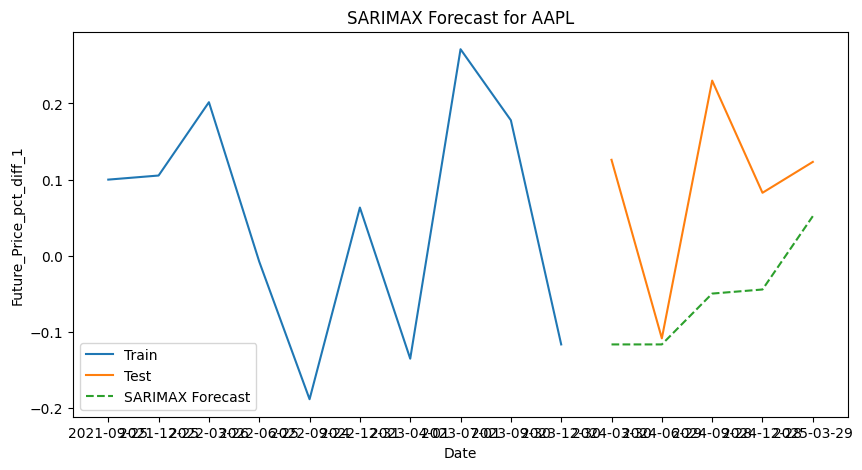

In [79]:
# SARIMAX challenger model for time series prediction

import matplotlib.pyplot as plt
import statsmodels.api as sm

# Example: Use one ticker for univariate SARIMAX (e.g., 'AAPL')
ticker = 'AAPL'
ticker_df = df[df['Ticker'] == ticker].copy()
ticker_df = ticker_df.sort_values('Date')

# Use the same split as before
train_ticker = ticker_df[ticker_df['Date'] < split_date]
test_ticker = ticker_df[ticker_df['Date'] >= split_date]

# SARIMAX expects a 1D array for endog
y_train_sarimax = train_ticker[target]
y_test_sarimax = test_ticker[target]

# You can tune (p,d,q) and (P,D,Q,s) for your data. Here is a simple example:
order = (1, 1, 1)
seasonal_order = (0, 1, 1, 12)  # Monthly seasonality, adjust as needed

# Fit SARIMAX
sarimax_model = sm.tsa.SARIMAX(
    y_train_sarimax,
    order=order,
    seasonal_order=seasonal_order,
    enforce_stationarity=False,
    enforce_invertibility=False
)
sarimax_result = sarimax_model.fit(disp=False)

# Forecast
n_test = len(y_test_sarimax)
sarimax_forecast = sarimax_result.forecast(steps=n_test)

# Evaluate
sarimax_rmse = np.sqrt(
    np.mean((sarimax_forecast - y_test_sarimax.values) ** 2))
print(f"SARIMAX Test RMSE for {ticker}: {sarimax_rmse:.4f}")

# Plot
plt.figure(figsize=(10, 5))
plt.plot(train_ticker['Date'], y_train_sarimax, label='Train')
plt.plot(test_ticker['Date'], y_test_sarimax, label='Test')
plt.plot(test_ticker['Date'], sarimax_forecast,
         label='SARIMAX Forecast', linestyle='--')
plt.title(f'SARIMAX Forecast for {ticker}')
plt.xlabel('Date')
plt.ylabel(target)
plt.legend()
plt.show()